In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img


**UNET**

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1346 - loss: 0.9408 - val_accuracy: 0.8017 - val_loss: 0.9034
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8249 - loss: 0.8984 - val_accuracy: 0.9377 - val_loss: 0.8699
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8951 - loss: 0.8682 - val_accuracy: 0.9326 - val_loss: 0.8548
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9079 - loss: 0.8558 - val_accuracy: 0.9268 - val_loss: 0.8460
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9088 - loss: 0.8502 - val_accuracy: 0.9204 - val_loss: 0.8397
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9087 - loss: 0.8484 - val_accuracy: 0.8838 - val_loss: 0.8424
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9090 - loss: 0.8471 - val_accuracy: 0.8917 - val_loss: 0.8383
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9149 - loss: 0.8445 - val_accuracy: 0.7773 - val_loss:

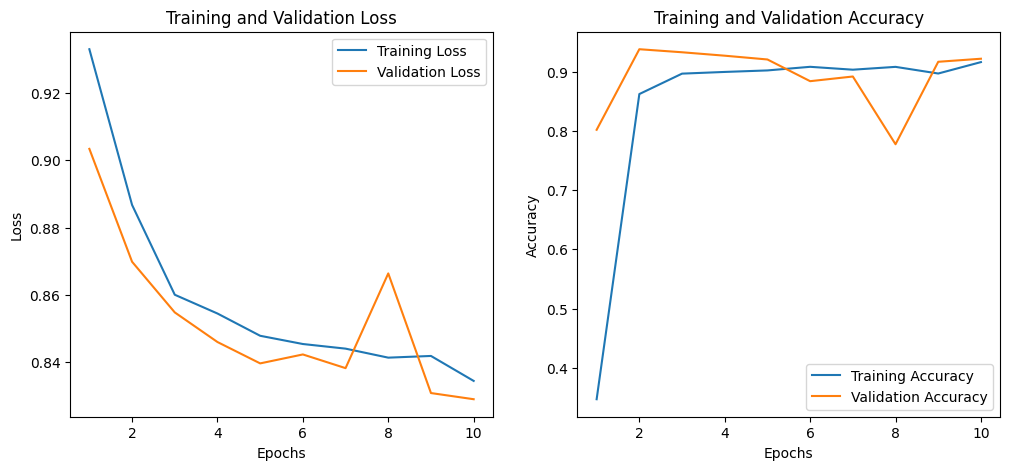

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


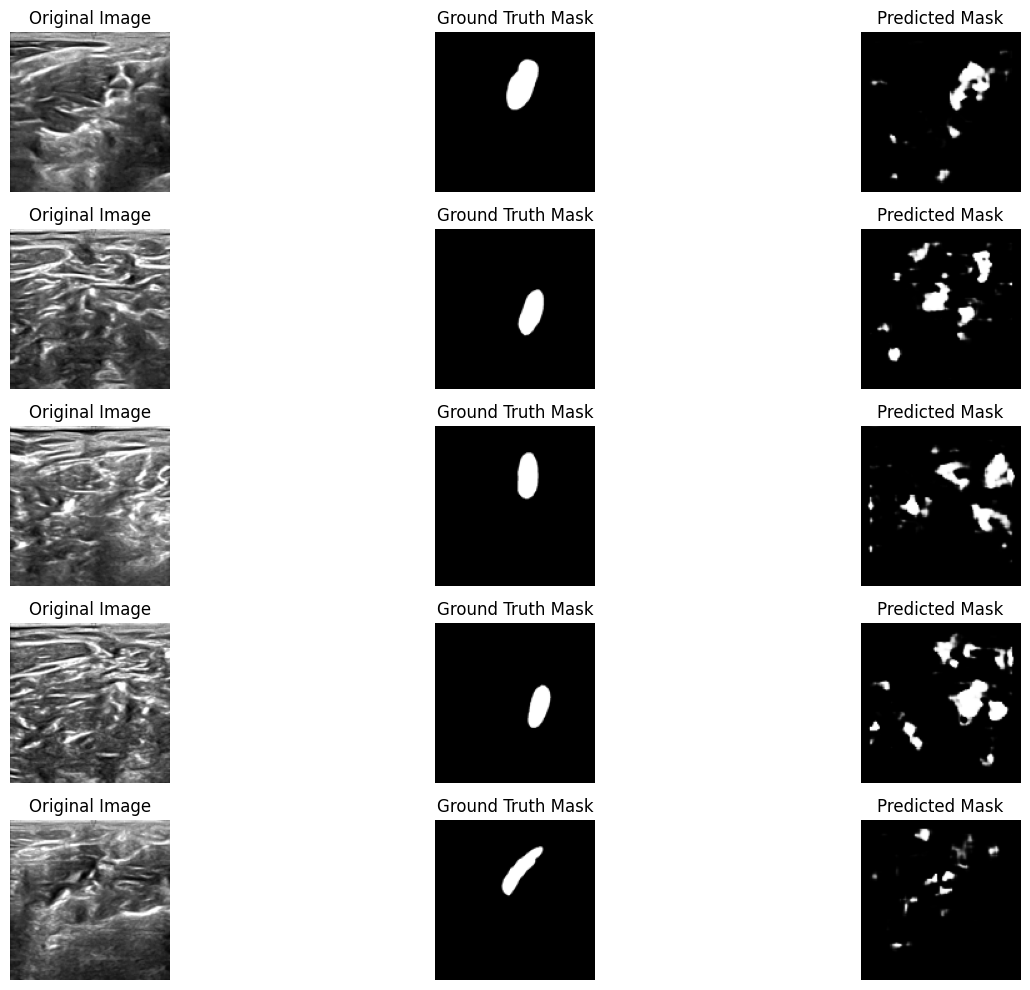

In [14]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters
img_size = (128, 128)
batch_size = 32
epochs = 10

# Define paths
image_folder = '/kaggle/input/image'
mask_folder = '/kaggle/input/mask/'

# Load and preprocess images
def load_images(folder, img_size=(128, 128)):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.tif'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(img_size)
            img = np.array(img) / 255.0
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)
            images.append(img)
    return np.array(images)

images = load_images(image_folder)
masks = load_images(mask_folder)

# Filter out blank masks
non_blank_indices = [i for i in range(len(masks)) if np.sum(masks[i]) > 0]
images = images[non_blank_indices]
masks = masks[non_blank_indices]

# Split dataset
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

# Use tf.data.Dataset
def create_dataset(images, masks, batch_size=8, shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_masks, batch_size=batch_size)
val_dataset = create_dataset(val_images, val_masks, batch_size=batch_size)

# Define U-Net model
def build_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Concatenate()([up1, conv2])
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    
    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Concatenate()([up2, conv1])
    conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv4)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy'])
    
    return model

# Dice Loss
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Metrics
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = sensitivity(y_true, y_pred)
    
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Initialize and train model
model = build_model(input_size=(128, 128, 1))
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

# Print final training and validation metrics
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

# Calculate evaluation metrics on the validation set
val_preds = model.predict(val_images)
val_preds = (val_preds > 0.5).astype(np.float32)

val_dice = dice_coefficient(val_masks, val_preds)
val_iou = iou(val_masks, val_preds)
val_sensitivity = sensitivity(val_masks, val_preds)
val_f1 = f1_score(val_masks, val_preds)

print(f"Validation Dice Coefficient: {K.eval(val_dice)}")
print(f"Validation IoU: {K.eval(val_iou)}")
print(f"Validation Sensitivity: {K.eval(val_sensitivity)}")
print(f"Validation F1 Score: {K.eval(val_f1)}")

# Plotting Training and Validation Loss and Accuracy
def plot_metrics(history):
    epochs_range = range(1, epochs + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

# Call the plot_metrics function to display loss and accuracy plots
plot_metrics(history)

# Visualization of random non-blank samples from validation data
def visualize_non_blank_predictions(val_images, val_masks, model, num_samples=5):
    plt.figure(figsize=(15, 10))
    non_blank_val_indices = [i for i in range(len(val_masks)) if np.sum(val_masks[i]) > 0]
    for i in range(num_samples):
        idx = np.random.choice(non_blank_val_indices)
        
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(val_images[idx].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(val_masks[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # Predicted Mask
        pred_mask = model.predict(val_images[idx][np.newaxis, ...])[0]
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Call the visualization function for non-blank predictions
visualize_non_blank_predictions(val_images, val_masks, model, num_samples=5)


**DenseNet**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      3,136 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 9,149,761 (34.90 MB)

 Trainable params: 9,077,185 (34.63 MB)

 Non-trainable params: 72,576 (283.50 KB)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1248s 9s/step - accuracy: 0.8577 - loss: 0.9057 - val_accuracy: 0.9818 - val_loss: 0.9816
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1136s 9s/step - accuracy: 0.9609 - loss: 0.7710 - val_accuracy: 0.9273 - val_loss: 0.9957
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1191s 9s/step - accuracy: 0.9712 - loss: 0.7193 - val_accuracy: 0.9283 - val_loss: 0.8455
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1131s 9s/step - accuracy: 0.9748 - loss: 0.6854 - val_accuracy: 0.9618 - val_loss: 0.7421
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1128s 9s/step - accuracy: 0.9760 - loss: 0.6786 - val_accuracy: 0.9811 - val_loss: 0.7580
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1122s 9s/step - accuracy: 0.9758 - loss: 0.6699 - val_accuracy: 0.9684 - val_loss: 0.7231
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1124s 9s/step - accuracy: 0.9777 - loss: 0.6511 - val_accuracy: 0.9709 - val_loss: 0.7281
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1126s 9s/step - accuracy: 0.9784 - loss: 0.6453 - 

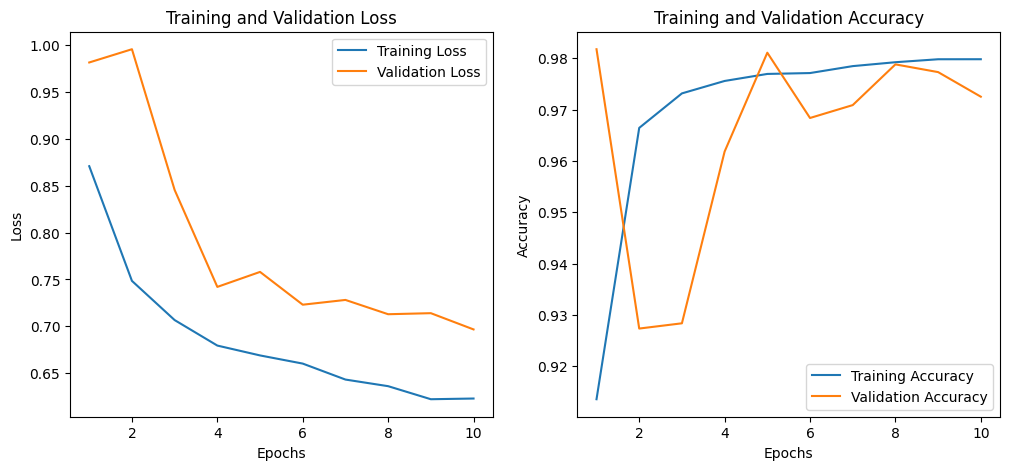

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


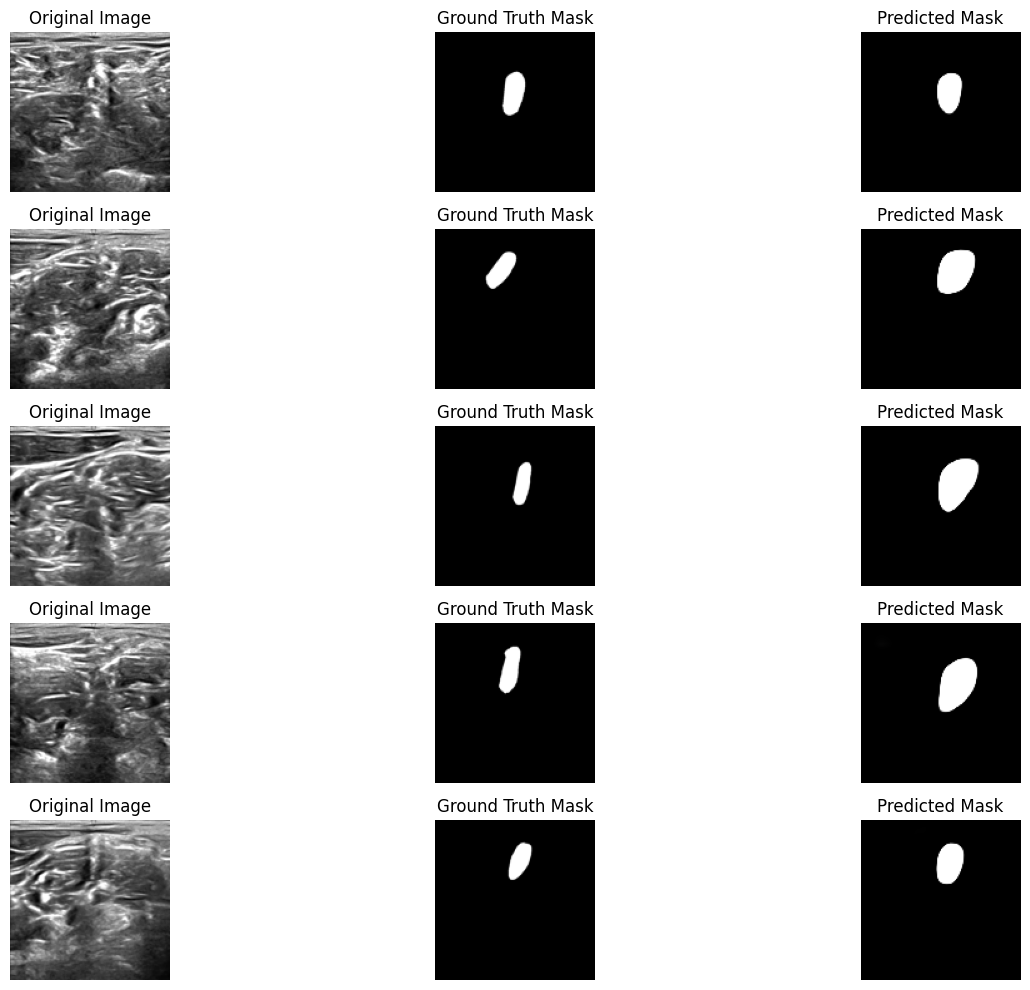

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Parameters
img_size = (128, 128)
batch_size = 32
epochs = 10

# Define paths
image_folder = '/kaggle/input/image'
mask_folder = '/kaggle/input/mask/'

# Load and preprocess images
def load_images(folder, img_size=(128, 128)):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.tif'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(img_size)
            img = np.array(img) / 255.0
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)
            images.append(img)
    return np.array(images)

images = load_images(image_folder)
masks = load_images(mask_folder)

# Split dataset
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

# Use tf.data.Dataset
def create_dataset(images, masks, batch_size=8, shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_masks, batch_size=batch_size)
val_dataset = create_dataset(val_images, val_masks, batch_size=batch_size)

# Define DenseNet-based segmentation model
def build_densenet_model(input_size=(128, 128, 1)):
    base_model = DenseNet169(include_top=False, weights=None, input_shape=input_size)

    # Encoder: Use DenseNet layers for downsampling
    encoder_output = base_model.get_layer("conv4_block32_concat").output

    # Decoder: Upsample and concatenate with previous layers
    up1 = UpSampling2D(size=(2, 2))(encoder_output)
    up1 = Conv2D(256, (3, 3), padding="same")(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation("relu")(up1)

    up2 = UpSampling2D(size=(2, 2))(up1)
    up2 = Conv2D(128, (3, 3), padding="same")(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation("relu")(up2)

    up3 = UpSampling2D(size=(2, 2))(up2)
    up3 = Conv2D(64, (3, 3), padding="same")(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation("relu")(up3)

    up4 = UpSampling2D(size=(2, 2))(up3)
    up4 = Conv2D(32, (3, 3), padding="same")(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation("relu")(up4)

    # Final segmentation output
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(up4)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy'])

    return model

# Dice Loss
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Metrics
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = sensitivity(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Initialize and train DenseNet-based model
model = build_densenet_model(input_size=(128, 128, 1))
model.summary()

# Training
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

 #Print final training and validation metrics
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

# Evaluate on validation set
val_preds = model.predict(val_images)
val_preds = (val_preds > 0.5).astype(np.float32)

# Metrics Calculation
val_dice = dice_coefficient(val_masks, val_preds)
val_iou = iou(val_masks, val_preds)
val_sensitivity = sensitivity(val_masks, val_preds)
val_f1 = f1_score(val_masks, val_preds)

print(f"Validation Dice Coefficient: {K.eval(val_dice)}")
print(f"Validation IoU: {K.eval(val_iou)}")
print(f"Validation Sensitivity: {K.eval(val_sensitivity)}")
print(f"Validation F1 Score: {K.eval(val_f1)}")

# Plotting Training and Validation Loss and Accuracy
def plot_metrics(history):
    epochs_range = range(1, epochs + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

# Call the plot_metrics function to display loss and accuracy plots
plot_metrics(history)

# Visualization of random non-blank samples from validation data
def visualize_non_blank_predictions(val_images, val_masks, model, num_samples=5):
    plt.figure(figsize=(15, 10))
    non_blank_val_indices = [i for i in range(len(val_masks)) if np.sum(val_masks[i]) > 0]
    for i in range(num_samples):
        idx = np.random.choice(non_blank_val_indices)
        
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(val_images[idx].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(val_masks[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # Predicted Mask
        pred_mask = model.predict(val_images[idx][np.newaxis, ...])[0]
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Call the visualization function for non-blank predictions
visualize_non_blank_predictions(val_images, val_masks, model, num_samples=5)



**VGG**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,592,385 (82.37 MB)

 Trainable params: 21,591,425 (82.36 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2291s 18s/step - accuracy: 0.8493 - loss: 0.9015 - val_accuracy: 0.3383 - val_loss: 0.9667
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2277s 18s/step - accuracy: 0.9542 - loss: 0.7936 - val_accuracy: 0.8575 - val_loss: 0.8960
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2302s 18s/step - accuracy: 0.9647 - loss: 0.7556 - val_accuracy: 0.9610 - val_loss: 0.7608
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2270s 18s/step - accuracy: 0.9674 - loss: 0.7388 - val_accuracy: 0.7606 - val_loss: 0.9269
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2272s 18s/step - accuracy: 0.9715 - loss: 0.7248 - val_accuracy: 0.5516 - val_loss: 0.9545
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2315s 18s/step - accuracy: 0.9717 - loss: 0.7252 - val_accuracy: 0.9201 - val_loss: 0.8275
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2310s 19s/step - accuracy: 0.9728 - loss: 0.7166 - val_accuracy: 0.9544 - val_loss: 0.7649
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 2285s 18s/step - accuracy: 0.9737 - loss: 0

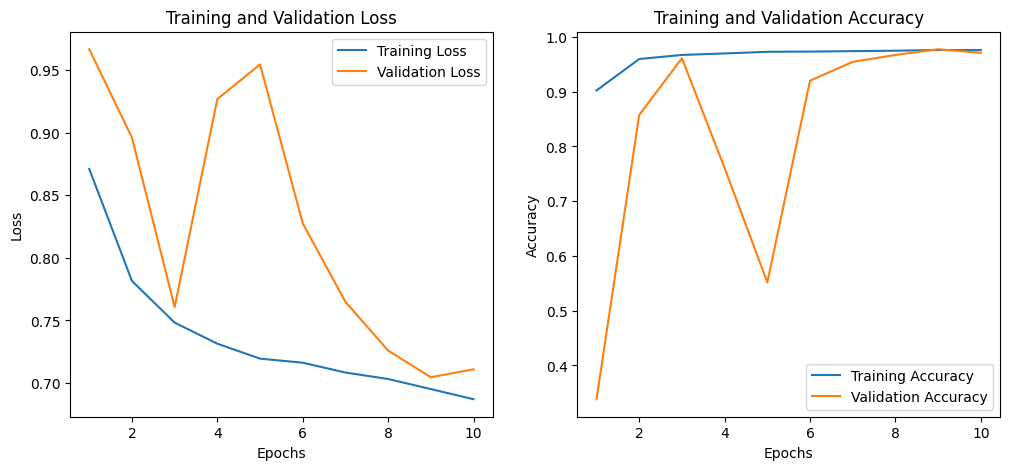

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


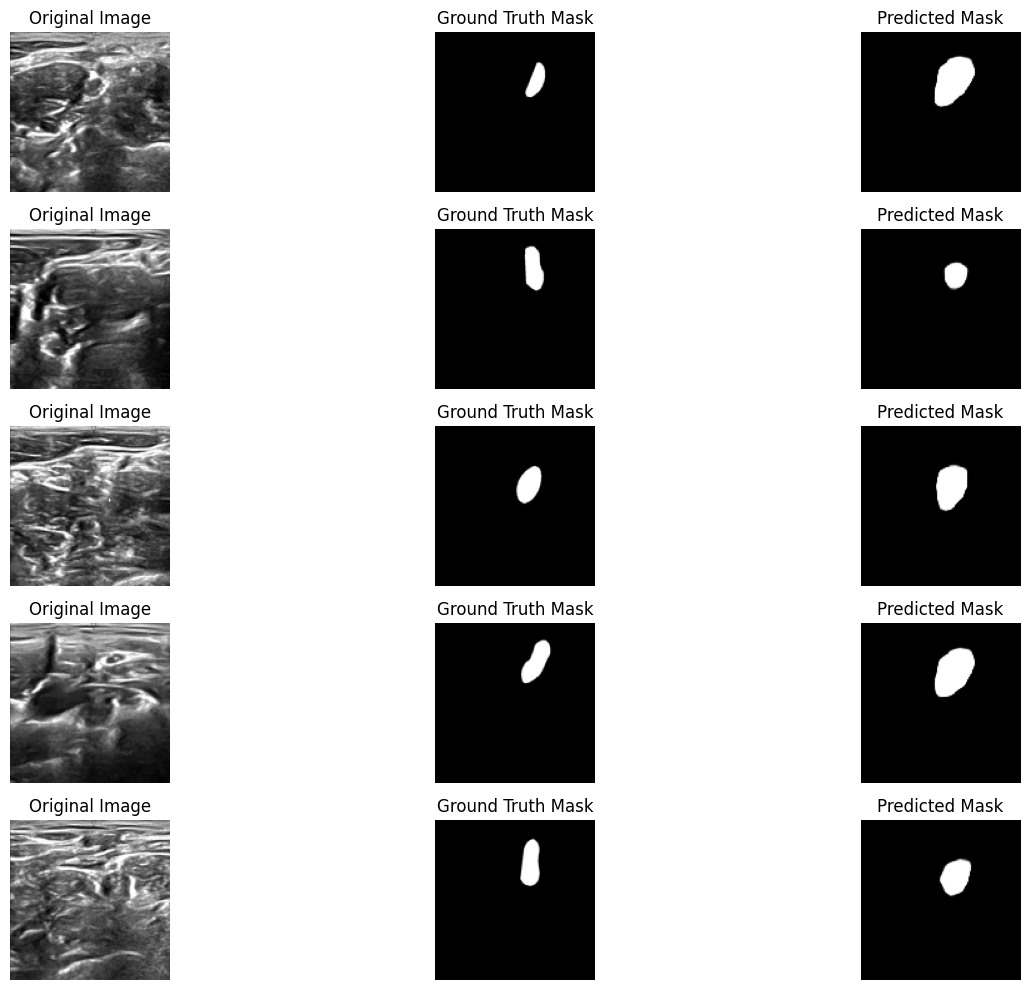

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Parameters
img_size = (128, 128)
batch_size = 32
epochs = 10

# Define paths
image_folder = '/kaggle/input/image'
mask_folder = '/kaggle/input/mask/'

# Load and preprocess images
def load_images(folder, img_size=(128, 128)):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.tif'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(img_size)
            img = np.array(img) / 255.0
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)
            images.append(img)
    return np.array(images)

images = load_images(image_folder)
masks = load_images(mask_folder)

# Split dataset
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

# Use tf.data.Dataset
def create_dataset(images, masks, batch_size=8, shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_masks, batch_size=batch_size)
val_dataset = create_dataset(val_images, val_masks, batch_size=batch_size)

# Define VGG19-based segmentation model
def build_vgg19_model(input_size=(128, 128, 1)):
    # Use VGG19 as encoder
    base_model = VGG19(include_top=False, weights=None, input_shape=input_size)

    # Encoder: Use VGG19 layers for downsampling
    encoder_output = base_model.get_layer("block5_conv4").output

    # Decoder: Upsample and concatenate with previous layers
    up1 = UpSampling2D(size=(2, 2))(encoder_output)
    up1 = Conv2D(256, (3, 3), padding="same")(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation("relu")(up1)

    up2 = UpSampling2D(size=(2, 2))(up1)
    up2 = Conv2D(128, (3, 3), padding="same")(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation("relu")(up2)

    up3 = UpSampling2D(size=(2, 2))(up2)
    up3 = Conv2D(64, (3, 3), padding="same")(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation("relu")(up3)

    up4 = UpSampling2D(size=(2, 2))(up3)
    up4 = Conv2D(32, (3, 3), padding="same")(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation("relu")(up4)

    # Final segmentation output
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(up4)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy'])

    return model

# Dice Loss
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Metrics
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = sensitivity(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Initialize and train VGG19-based model
model = build_vgg19_model(input_size=(128, 128, 1))
model.summary()

# Training
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

 #Print final training and validation metrics
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

# Evaluate on validation set
val_preds = model.predict(val_images)
val_preds = (val_preds > 0.5).astype(np.float32)

# Metrics Calculation
val_dice = dice_coefficient(val_masks, val_preds)
val_iou = iou(val_masks, val_preds)
val_sensitivity = sensitivity(val_masks, val_preds)
val_f1 = f1_score(val_masks, val_preds)

print(f"Validation Dice Coefficient: {K.eval(val_dice)}")
print(f"Validation IoU: {K.eval(val_iou)}")
print(f"Validation Sensitivity: {K.eval(val_sensitivity)}")
print(f"Validation F1 Score: {K.eval(val_f1)}")

# Plotting Training and Validation Loss and Accuracy
def plot_metrics(history):
    epochs_range = range(1, epochs + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

# Call the plot_metrics function to display loss and accuracy plots
plot_metrics(history)

# Visualization of random non-blank samples from validation data
def visualize_non_blank_predictions(val_images, val_masks, model, num_samples=5):
    plt.figure(figsize=(15, 10))
    non_blank_val_indices = [i for i in range(len(val_masks)) if np.sum(val_masks[i]) > 0]
    for i in range(num_samples):
        idx = np.random.choice(non_blank_val_indices)
        
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(val_images[idx].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(val_masks[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # Predicted Mask
        pred_mask = model.predict(val_images[idx][np.newaxis, ...])[0]
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Call the visualization function for non-blank predictions
visualize_non_blank_predictions(val_images, val_masks, model, num_samples=5)


**MobileNet**

/tmp/ipykernel_30/1972309630.py:57: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ concatenate_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,662,721 (10.16 MB)

 Trainable params: 2,645,441 (10.09 MB)

 Non-trainable params: 17,280 (67.50 KB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.9785 - loss: 0.1879 - val_accuracy: 0.9865 - val_loss: 0.0625
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9852 - loss: 0.0692 - val_accuracy: 0.9865 - val_loss: 0.0590
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9862 - loss: 0.0483 - val_accuracy: 0.9865 - val_loss: 0.0592
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9850 - loss: 0.0396 - val_accuracy: 0.9865 - val_loss: 0.0833
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9864 - loss: 0.0311 - val_accuracy: 0.9865 - val_loss: 0.1088
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9862 - loss: 0.0269 - val_accuracy: 0.9865 - val_loss: 0.1001
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9856 - loss: 0.0234 - val_accuracy: 0.9865 - val_loss: 0.1789
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9866 - loss: 0.0201 - val_accuracy: 0.9865 - val_loss

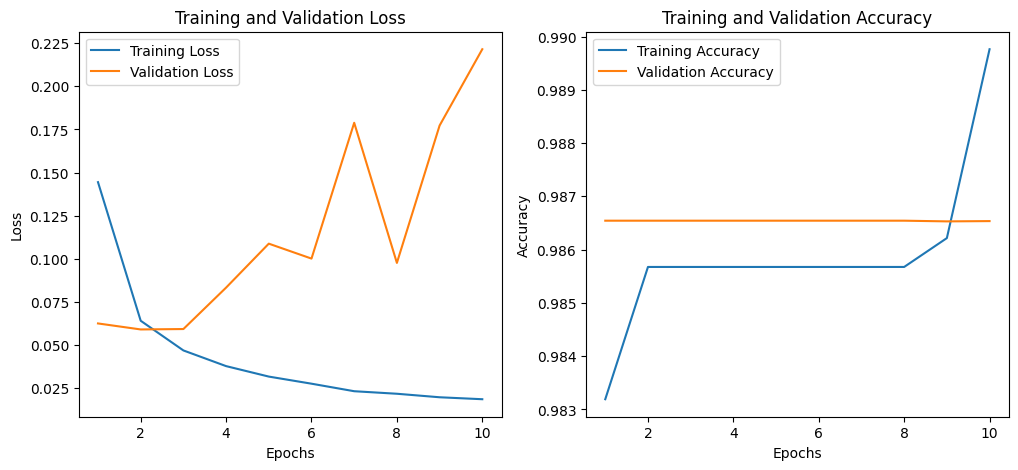

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


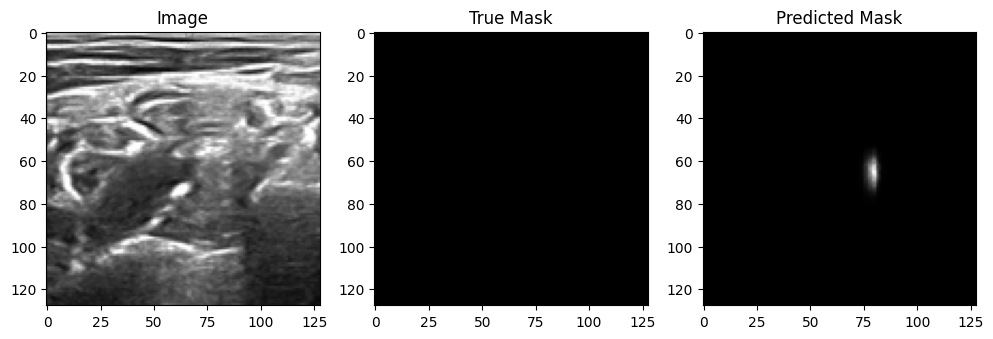

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


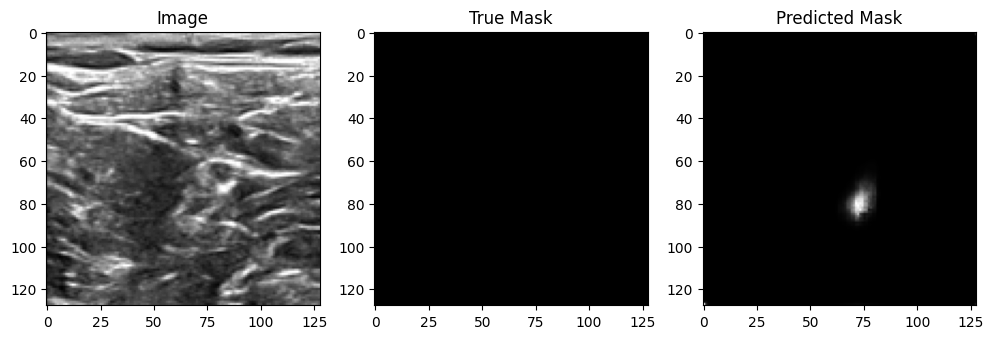

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


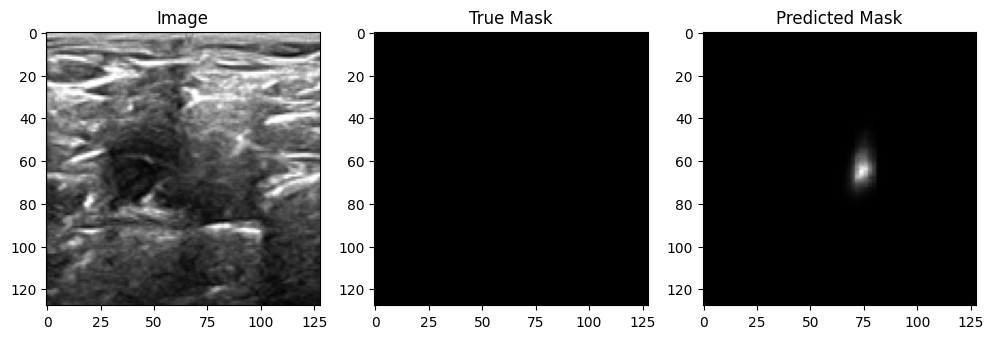

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


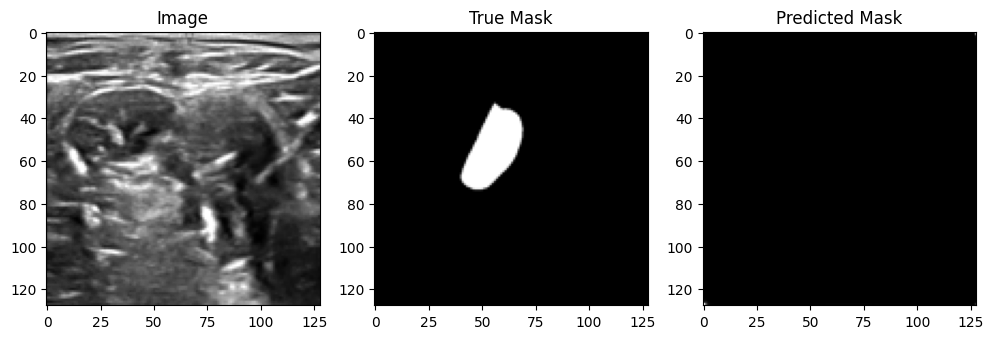

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


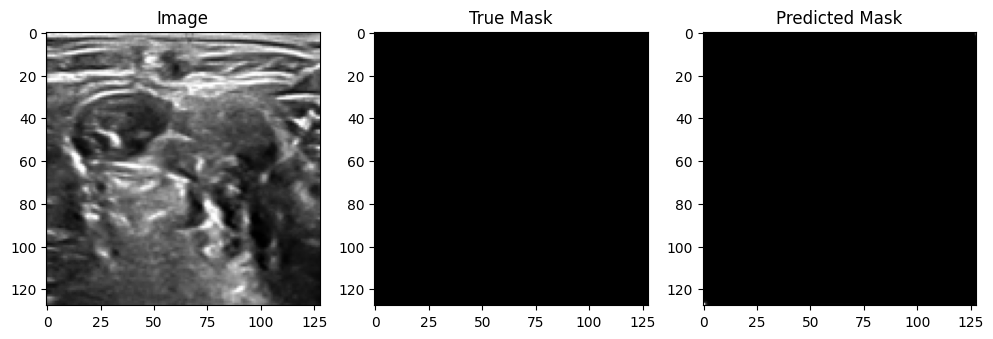

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Parameters
img_size = (128, 128)
batch_size = 32
epochs = 10
sample_size = 500  # Number of images to sample

# Define paths
image_folder = '/kaggle/input/image'
mask_folder = '/kaggle/input/mask/'

# Load and preprocess images
def load_images(folder, img_size=(128, 128), sample_size=None):
    images = []
    for filename in sorted(os.listdir(folder))[:sample_size]:
        if filename.endswith('.tif'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(img_size)
            img = np.array(img) / 255.0
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)
            images.append(img)
    return np.array(images)

images = load_images(image_folder, img_size, sample_size=sample_size)
masks = load_images(mask_folder, img_size, sample_size=sample_size)

# Split dataset
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

# Create tf.data.Dataset
def create_dataset(images, masks, batch_size=8, shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_masks, batch_size=batch_size)
val_dataset = create_dataset(val_images, val_masks, batch_size=batch_size)

# Define MobileNet-based model
def build_mobilenet_model(input_size=(128, 128, 1)):
    inputs = Input(shape=input_size)

    # MobileNetV2 as backbone
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, 
                                                   input_tensor=Concatenate()([inputs, inputs, inputs]))
    
    # Extract feature layers
    skip1 = base_model.get_layer("block_1_expand_relu").output  # Size 64x64
    skip2 = base_model.get_layer("block_3_expand_relu").output  # Size 32x32
    skip3 = base_model.get_layer("block_6_expand_relu").output  # Size 16x16
    bottleneck = base_model.get_layer("block_13_expand_relu").output  # Size 8x8

    # Decoder
    up1 = UpSampling2D((2, 2))(bottleneck)
    up1 = Conv2D(256, (3, 3), activation="relu", padding="same")(up1)
    up1 = Concatenate()([up1, skip3])
    
    up2 = UpSampling2D((2, 2))(up1)
    up2 = Conv2D(128, (3, 3), activation="relu", padding="same")(up2)
    up2 = Concatenate()([up2, skip2])
    
    up3 = UpSampling2D((2, 2))(up2)
    up3 = Conv2D(64, (3, 3), activation="relu", padding="same")(up3)
    up3 = Concatenate()([up3, skip1])
    
    up4 = UpSampling2D((2, 2))(up3)
    up4 = Conv2D(32, (3, 3), activation="relu", padding="same")(up4)
    
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(up4)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
model = build_mobilenet_model(input_size=(128, 128, 1))
model.summary()

# Function to plot metrics
def plot_metrics(history):
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

# Metrics Calculation
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return 2 * intersection / (np.sum(y_true) + np.sum(y_pred))

def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

def sensitivity(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    false_negative = np.sum(y_true * (1 - y_pred))
    return true_positive / (true_positive + false_negative)

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

# Print final training and validation metrics
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

# Evaluate on validation set
val_preds = model.predict(val_images)

# Convert continuous predictions to binary labels
val_preds_binary = (val_preds > 0.5).astype(np.float32)

# Ensure the masks are also binary
val_masks_binary = (val_masks > 0.5).astype(np.float32)

# Metrics Calculation
val_dice = dice_coefficient(val_masks_binary, val_preds_binary)
val_iou = iou(val_masks_binary, val_preds_binary)
val_sensitivity = sensitivity(val_masks_binary, val_preds_binary)

# Calculate F1 score after thresholding the predictions
val_f1 = f1_score(val_masks_binary.flatten(), val_preds_binary.flatten())

print(f"Validation F1 Score: {val_f1}")
print(f"Validation Dice Coefficient: {val_dice}")
print(f"Validation IoU: {val_iou}")
print(f"Validation Sensitivity: {val_sensitivity}")
print(f"Validation F1 Score: {val_f1}")

# Call the plot_metrics function to display loss and accuracy plots
plot_metrics(history)

# Visualization of random non-blank samples from validation data
def visualize_non_blank_predictions(val_images, val_masks, model):
    # Pick random images and masks
    indices = np.random.choice(len(val_images), size=5, replace=False)
    for idx in indices:
        image = val_images[idx]
        mask = val_masks[idx]
        pred = model.predict(np.expand_dims(image, axis=0))[0]

        # Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Image")
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.show()

visualize_non_blank_predictions(val_images, val_masks, model)


**SK-U-NET**

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9776 - loss: 0.4359 - val_accuracy: 0.9881 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9867 - loss: 0.0762 - val_accuracy: 0.9881 - val_loss: 0.0533 - learning_rate: 0.0010
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9873 - loss: 0.0507 - val_accuracy: 0.9881 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9873 - loss: 0.0488 - val_accuracy: 0.9881 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9883 - loss: 0.0430 - val_accuracy: 0.9881 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9881 - loss: 0.0434 - val_accuracy: 0.9881 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9886 - loss: 0.0407 - val_accuracy: 

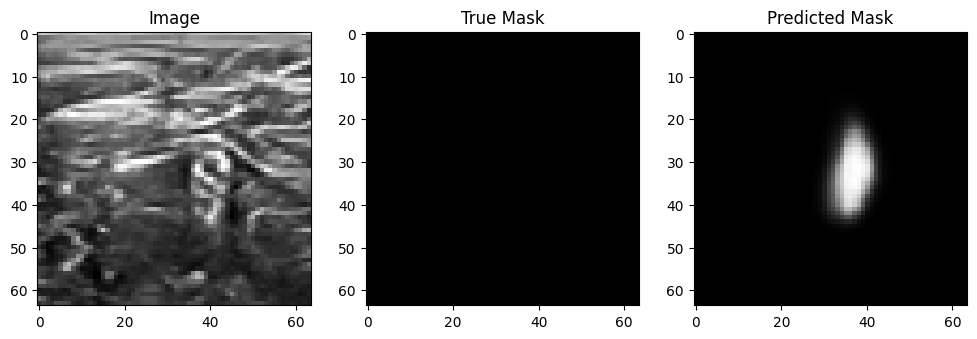

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


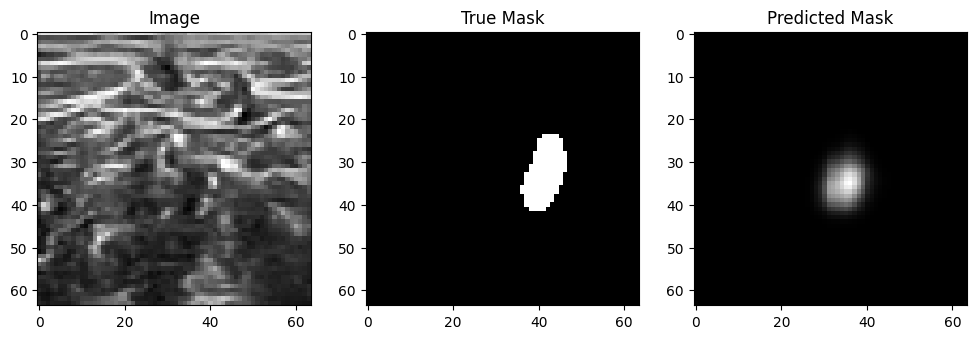

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


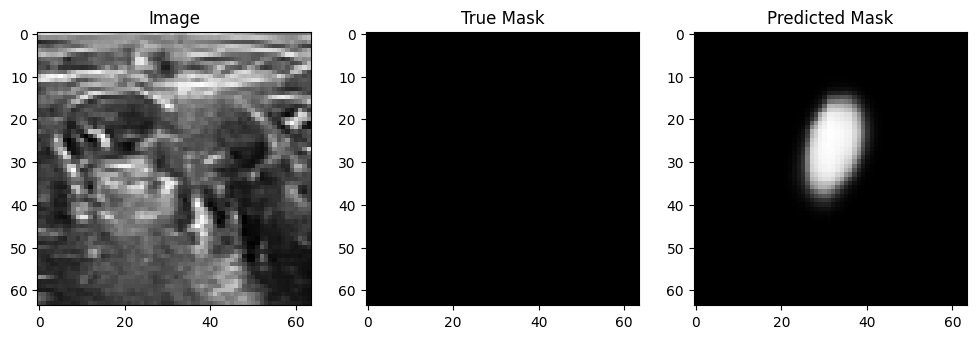

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


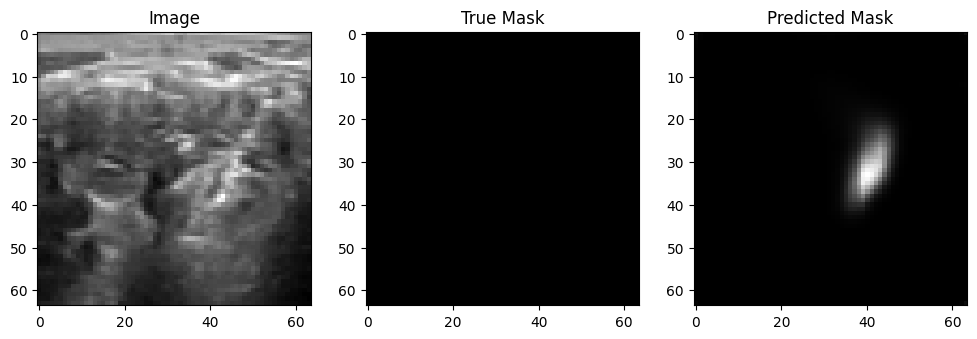

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


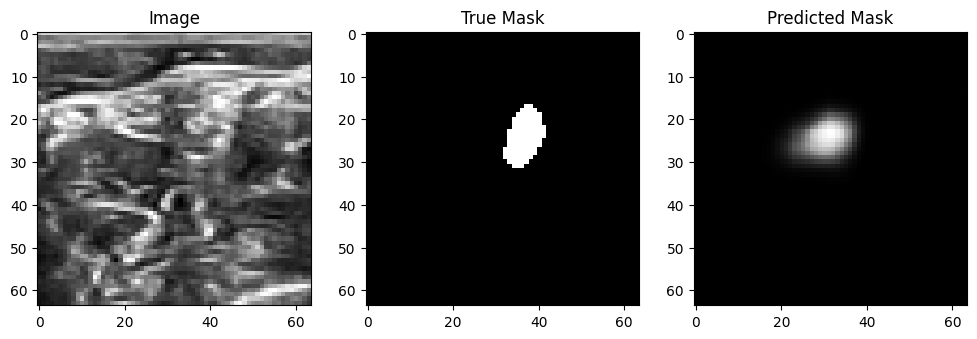

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, UpSampling2D, MaxPooling2D, Concatenate,
    GlobalAveragePooling2D, Dense, Reshape, Multiply, Input, Lambda, Add
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Parameters
img_size = (64, 64)
batch_size = 16
epochs = 25  # Increased to allow for more training
sample_size = 500

# Define paths
image_folder = '/kaggle/input/image'
mask_folder = '/kaggle/input/mask/'

# Load and preprocess images
def load_images(folder, img_size=(64, 64), sample_size=None):
    images = []
    for filename in sorted(os.listdir(folder))[:sample_size]:
        if filename.endswith('.tif'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(img_size)
            img = np.array(img) / 255.0  # Normalize to [0, 1]
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
    return np.array(images)

images = load_images(image_folder, img_size, sample_size=sample_size)
masks = load_images(mask_folder, img_size, sample_size=sample_size)

# Ensure masks are binary
masks = (masks > 0.5).astype(np.float32)

# Split dataset
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)

# Create tf.data.Dataset
def create_dataset(images, masks, batch_size=16, shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images, train_masks, batch_size=batch_size)
val_dataset = create_dataset(val_images, val_masks, batch_size=batch_size)

# Selective Kernel Block
def selective_kernel_block(x, filters):
    global_pool = GlobalAveragePooling2D()(x)
    fc1 = Dense(filters // 16, activation='relu')(global_pool)
    fc2 = Dense(filters * 2, activation='sigmoid')(fc1)
    fc2 = Reshape((1, 1, filters * 2))(fc2)

    def split_fn(tensor):
        return tf.split(tensor, num_or_size_splits=2, axis=-1)

    split1, split2 = Lambda(split_fn)(fc2)

    x_projected = Conv2D(filters, (1, 1), activation='linear', padding='same')(x)
    x1 = Multiply()([x_projected, split1])
    x2 = Multiply()([x_projected, split2])

    return Add()([x1, x2])

# Build SK-U-Net Model
def build_sk_unet(input_size=(64, 64, 1)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = selective_kernel_block(conv1, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = selective_kernel_block(conv2, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = selective_kernel_block(conv3, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = selective_kernel_block(conv4, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    
    # Bottleneck
    bottleneck = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = selective_kernel_block(bottleneck, 1024)
    
    # Decoder
    up1 = UpSampling2D((2, 2))(bottleneck)
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    up1 = Concatenate()([up1, conv4])
    up1 = selective_kernel_block(up1, 512)
    
    up2 = UpSampling2D((2, 2))(up1)
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    up2 = Concatenate()([up2, conv3])
    up2 = selective_kernel_block(up2, 256)
    
    up3 = UpSampling2D((2, 2))(up2)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = Concatenate()([up3, conv2])
    up3 = selective_kernel_block(up3, 128)
    
    up4 = UpSampling2D((2, 2))(up3)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    up4 = Concatenate()([up4, conv1])
    up4 = selective_kernel_block(up4, 64)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up4)
    
    model = Model(inputs, outputs)
    return model

# Compile model with weighted loss
model = build_sk_unet(input_size=(64, 64, 1))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Train model with learning rate scheduler
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[lr_schedule])

# Predictions and Metrics
val_predictions = model.predict(val_images)
val_predictions_binary = (val_predictions >= 0.5).astype(int)
val_masks_binary = (val_masks >= 0.5).astype(int)

# Metrics
intersection = np.sum(val_predictions_binary * val_masks_binary)
dice_coeff = (2. * intersection) / (np.sum(val_predictions_binary) + np.sum(val_masks_binary))
iou = intersection / (np.sum(val_predictions_binary) + np.sum(val_masks_binary) - intersection)
sensitivity = intersection / np.sum(val_masks_binary)
f1 = f1_score(val_masks_binary.flatten(), val_predictions_binary.flatten())

print(f"Dice Coefficient: {dice_coeff}")
print(f"IoU: {iou}")
print(f"Sensitivity: {sensitivity}")
print(f"F1 Score: {f1}")

# Visualization
def visualize_predictions(images, masks, model, num_samples=5):
    indices = np.random.choice(len(images), size=num_samples, replace=False)
    for idx in indices:
        image = images[idx]
        mask = masks[idx]
        pred = model.predict(np.expand_dims(image, axis=0))[0]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title("Image")
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.show()

visualize_predictions(val_images, val_masks, model)


**TRANSCGUNET**

Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 229s 801ms/step - accuracy: 0.4882 - loss: 0.9824 - val_accuracy: 0.7840 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 218s 774ms/step - accuracy: 0.9094 - loss: 0.9819 - val_accuracy: 0.9750 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 217s 771ms/step - accuracy: 0.9724 - loss: 0.9916 - val_accuracy: 0.9750 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 219s 778ms/step - accuracy: 0.9724 - loss: 0.9916 - val_accuracy: 0.9750 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 262s 778ms/step - accuracy: 0.9724 - loss: 0.9916 - val_accuracy: 0.9750 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 220s 780ms/step - accuracy: 0.9724 - loss: 0.9916 - val_accuracy: 0.9750 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 259s 768ms/step - accura

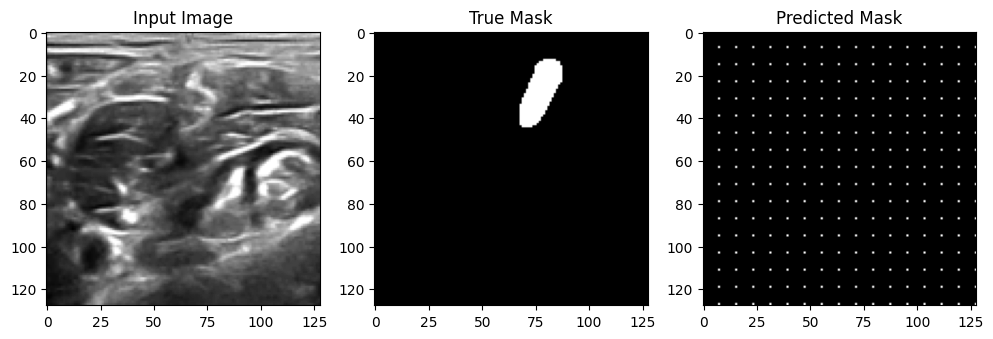

Dice Coefficient: 0.01202452927827835
IoU: 0.006048630457371473
Sensitivity: 0.015764499083161354
F1 Score: 0.02376331388950348


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Concatenate, Conv2DTranspose)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define paths
image_folder = '/kaggle/input/image'
mask_folder = '/kaggle/input/mask/'

# Load and preprocess data
def load_data(image_dir, mask_dir, target_size=(128, 128)):
    images, masks = [], []

    for filename in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, filename)
        try:
            img = Image.open(img_path).convert('L')  # Grayscale
            img = img.resize(target_size)
            img = np.expand_dims(np.array(img), axis=-1)
            images.append(img)
        except Exception as e:
            print(f"Skipping file {img_path} due to error: {e}")

    for filename in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, filename)
        try:
            mask = Image.open(mask_path).convert('L')  # Grayscale
            mask = mask.resize(target_size)
            mask = np.expand_dims(np.array(mask), axis=-1)
            # Ensure binary masks
            mask = (mask > 127).astype(np.float32)
            masks.append(mask)
        except Exception as e:
            print(f"Skipping file {mask_path} due to error: {e}")

    images = np.array(images, dtype=np.float32) / 255.0
    masks = np.array(masks, dtype=np.float32)
    return images, masks

# Load data
images, masks = load_data(image_folder, mask_folder)

# Split into training and validation sets
split_ratio = 0.8
split_index = int(len(images) * split_ratio)
train_images, val_images = images[:split_index], images[split_index:]
train_masks, val_masks = masks[:split_index], masks[split_index:]

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(16).prefetch(tf.data.AUTOTUNE)

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    return 1 - (numerator + 1e-7) / (denominator + 1e-7)

# Define the TransCGUNet model
def build_transcgunet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Contracting path (encoder)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = MaxPooling2D((2, 2))(x1)

    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPooling2D((2, 2))(x2)

    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x3 = MaxPooling2D((2, 2))(x3)

    # Transformer-inspired attention mechanism (simplified)
    attention = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    attention = Dropout(0.5)(attention)

    # Expansive path (decoder)
    x4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(attention)
    x4 = Concatenate()([x4, x2])

    x5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x4)
    x5 = Concatenate()([x5, x1])

    # Final upsampling to match target size
    x6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x5)

    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x6)

    model = Model(inputs, output)
    return model

# Build and compile the model
model = build_transcgunet()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=dice_loss,
              metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch > 8:
        return lr * 0.5
    return lr

lr_schedule = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30,
                    callbacks=[lr_schedule])

# Evaluate final metrics
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

# Get predictions on validation data
val_predictions = model.predict(val_images)

# Threshold predictions for binary masks
threshold = 0.5
val_predictions_binary = (val_predictions >= threshold).astype(np.float32)


# Debugging: visualize one prediction and corresponding mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(val_images[0].squeeze(), cmap='gray')
plt.title("Input Image")
plt.subplot(1, 3, 2)
plt.imshow(val_masks[0].squeeze(), cmap='gray')
plt.title("True Mask")
plt.subplot(1, 3, 3)
plt.imshow(val_predictions_binary[0].squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.show()

# TensorFlow-based metric calculation
def calculate_metrics_tf(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice = (2.0 * intersection) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + 1e-7)
    iou = intersection / (
        tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection + 1e-7)
    sensitivity = tf.reduce_sum(y_true_flat * y_pred_flat) / (tf.reduce_sum(y_true_flat) + 1e-7)
    f1 = (2 * dice) / (1 + dice + 1e-7)
    return dice.numpy(), iou.numpy(), sensitivity.numpy(), f1.numpy()

# Evaluate metrics using TensorFlow operations
dice, iou, sensitivity, f1 = calculate_metrics_tf(val_masks, val_predictions_binary)

print(f"Dice Coefficient: {dice}")
print(f"IoU: {iou}")
print(f"Sensitivity: {sensitivity}")
print(f"F1 Score: {f1}")
